BB3 Site Separator
Written by Sebastian DiGeronimo

**Important**
This script should read a BB3 file that contains many stations (sometimes many cruises) and separate them into stations. The file format is MBON_MM_DD_YYYYTHHmmss_site_ID (i.e MBON_07_01_20T183009_site_KW2). 

I've tried to circumvent errors by adding exceptions to the list, some examples of errors:
* 01/07/20	10:25:31	470	118	532	128	650	170	536
  01/07/20	10:25:32	470	115	532	147	65:34	470	115	532	136	650	201	536 <-- error

* 01/07/20	10:25:59	470	120	532	200	650	165	534 
  01/07/20	1:00	470	132	532	196	650	450	534 <-- error
  
* 01/07/20	10:26:52	470	113	532	127	650	159	532
  01/07/20	107/20	10:26:56	470	124	532	127	650	155	532 <-- error
  
* 01/07/20	10:27:19	470	107	532	145	650	236	532
  01/07/20	10:27:20	470	110	532	 <-- error
 
* 01/07/20	11:34:51	470	54	532	80	650	364	536
  01/07/20	1132	82	650	362	536 <-- error
  
* 01/07/20	11:36:12	470	92	532	102	650	118	533
  0	650	149	534 <-- error
  
Some problems I don't know how to solve is if the time stamp jumps by more than 5 min thus creating a new station file, when the line after goes back to the previous file:
01/07/20	11:36:36	470	91	532	92	650	113	533
01/07/20	11:46:37	470	91	532	98	650	110	533 <-- this will create a new file, even though its just an error 
01/07/20	11:36:38	470	92	532	94	650	108	532

In [1]:
from datetime import timedelta
from datetime import datetime
import os
from parse import parse
from IPython.display import display
import pandas
import numpy as np

**Definitions** 

In [3]:
# to check if a file path for a cruise exist already, if not will make one
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

# checks if a value is able to be converted to float, else NaN        
def my_conv(x): 
    try: 
        return np.float64(x)
    except ValueError: 
        return np.nan

You may customize the folder of input, usually should be a cruise ID (i.e. WS18256 for Walton Smith 2018 Julian Day)

In [4]:
# folder_cust = input("do you want a custom folder name (yes|y|YES)? (default is BB3/)")
# if folder_cust == "yes" or folder_cust == "y" or folder_cust == "YES":
#     folder_name = input("what do you want directory to be?") + '/'
# else:
#     folder_name = 'BB3/'        # comment out if want to costumize folder
# ensure_dir(folder_name)

folder_name = 'BB3/'        # comment out if want to customize folder
ensure_dir(folder_name)

This allows you to choose a file to run. 
**This could be improved by having it search all files in a directory within the else statement** Currently, you need can put in file *a prior*

In [5]:
# choose_file = input("do you want a specific file ran (yes|y|YES)?")
# if choose_file == "yes" or choose_file == "y" or choose_file == "YES":
#     FILEPATH = input('Whats the file path?')
# else:
#     FILEPATH = 'WS20006_full_download.raw'


Read a file

In [6]:
FILEPATH = "data/WS19266_BB3.raw"

# sets datetime as month/day/year hour:minute:second (i.e 7/25/2018 13:35:23)
dt_fmt = "%m/%d/%y  %H:%M:%S"

# read the tab-separated-values file (`.raw` = `.tsv`)
bb3_df = pandas.read_csv(
    FILEPATH, 
    sep='\s+',
    on_bad_lines='skip',  # default is 'error'. can also use 'warn' and 'skip'
    names=["date","time","470nm", "470nm_data","532nm", "532nm_data", "650nm", "650nm_data", "therm"],
    skiprows=1,
    # na_filter = 'TRUE',
    # TODO: use more features to better filter
    converters={"470nm":my_conv, "470nm_data":my_conv,"532nm":my_conv, "532nm_data":my_conv, "650nm":my_conv, 
           "650nm_data":my_conv, "therm":my_conv},  # this should fix a lot
    parse_dates = {'dt':["date", "time"]}  # this should parse the two columns together as one datetime
)

# convert datetime column to type datetime[ns], will convert non-match to NaT
bb3_df['dt']= pandas.to_datetime(
    bb3_df['dt'], 
    errors = 'coerce',
    format = dt_fmt,
    exact = True
) 

# drop rows with NaN or NaT, this will remove any rows with bad datetimes 
bb3_df = bb3_df.dropna()

# convert the dt col from string to datetime object
bb3_df.index = bb3_df.dt

#---------------------------------------------------------------------
# index for values being wavelengths of 470, 532 or 650 nm
idx = (
    (bb3_df['470nm'] == 470) & 
    (bb3_df['532nm'] == 532) & 
    (bb3_df['650nm'] == 650)
)

bb3_df = bb3_df.loc[idx,:]

# # drop useless columns
bb3_df.drop(['dt','470nm', '532nm', '650nm'], axis=1, inplace = True)

#---------------------------------------------------------------------
# === filter out data outside known bounds of 12-bit sensors
#TODO: filter out the out-of-bounds data

# bb3_df.to_csv("test.csv", sep = '\t', index=True)

# now you can use the pandas dataframe
SEPARATOR = "="*100  # this creates big string like `=====================` with 302 `=` characters
display(SEPARATOR)
display(bb3_df.describe())
display(SEPARATOR)
display(bb3_df.info())
display(SEPARATOR)
display(bb3_df)

'===================================================================================================='

,470nm_data,532nm_data,650nm_data,therm
count,2.985200e+04,2.985200e+04,2.985200e+04,29852.000000
mean,2.262053e+03,1.077420e+03,5.540755e+03,787.422719
std,2.390589e+05,2.477435e+04,3.434294e+05,10595.594533
min,-2.680000e+02,-1.980000e+02,-2.670000e+02,-1.000000
25%,1.250000e+02,1.490000e+02,1.820000e+02,517.000000
50%,2.905000e+02,3.770000e+02,5.280000e+02,521.000000
75%,1.056250e+03,1.109000e+03,3.792750e+03,524.000000
max,4.130413e+07,4.130130e+06,4.130413e+07,534130.000000


'===================================================================================================='

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29852 entries, 2019-07-29 12:06:15 to 2019-09-29 17:36:12
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   470nm_data  29852 non-null  float64
 1   532nm_data  29852 non-null  float64
 2   650nm_data  29852 non-null  float64
 3   therm       29852 non-null  float64
dtypes: float64(4)
memory usage: 1.1 MB


None

'===================================================================================================='

,470nm_data,532nm_data,650nm_data,therm
dt,,,,
2019-07-29 12:06:15,2153.0,2043.0,4130.0,536.0
2019-07-29 12:06:16,2151.0,2034.0,4130.0,536.0
2019-07-29 12:06:17,2121.0,1994.0,4130.0,535.0
2019-07-29 12:06:18,2119.0,1992.0,4130.0,535.0
2019-07-29 12:06:19,2117.0,1991.0,4130.0,535.0
...,...,...,...,...
2019-09-29 05:10:20,2045.0,1537.0,4130.0,519.0
2019-09-29 05:10:21,1405.0,1480.0,4130.0,519.0
2019-09-29 05:10:22,1626.0,1484.0,41370.0,121.0


<AxesSubplot:xlabel='dt'>

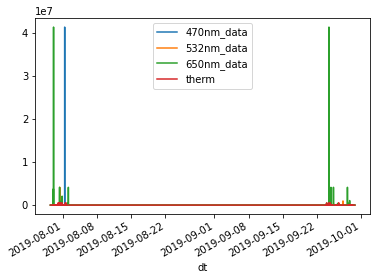

In [7]:
bb3_df.plot()



post-bounds filter:


,470nm_data,532nm_data,650nm_data,therm
count,11045.000000,11045.000000,11045.000000,11045.000000
mean,343.131010,445.123495,869.558443,517.524400
std,371.733933,500.691216,1083.834383,25.589509
min,4.000000,1.000000,1.000000,5.000000
25%,120.000000,146.000000,168.000000,515.000000
50%,195.000000,254.000000,321.000000,518.000000
75%,440.000000,499.000000,1196.000000,522.000000
max,4085.000000,4051.000000,4094.000000,1190.000000


<AxesSubplot:xlabel='dt'>

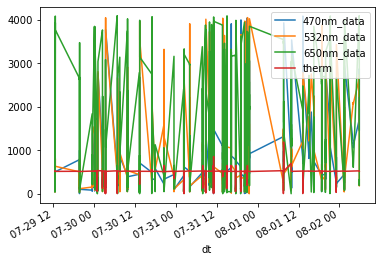

In [23]:
from datetime import datetime
# print('\n\npost-drop & convert:')
# display(bb3_df.describe(include='all'))
# display(bb3_df.info())
bb3_df_clean = bb3_df
# === filter out data outside known bounds of 12-bit sensors
SENSOR_MIN = 0
SENSOR_MAX = 4095
bb3_df_clean = bb3_df_clean[
    (bb3_df_clean['470nm_data'] > SENSOR_MIN) &
    (bb3_df_clean['470nm_data'] < SENSOR_MAX) &
    (bb3_df_clean['532nm_data'] > SENSOR_MIN) &
    (bb3_df_clean['532nm_data'] < SENSOR_MAX) &
    (bb3_df_clean['650nm_data'] > SENSOR_MIN) &
    (bb3_df_clean['650nm_data'] < SENSOR_MAX) &
    (bb3_df_clean['therm'] > SENSOR_MIN) &
    (bb3_df_clean['therm'] < SENSOR_MAX)
]

# === separate different cruises using a known data between them
CRUISE_SPLIT_DATE = datetime(2019,8,8)
bb3_df_first_cruise = bb3_df_clean[
    (bb3_df_clean.index < CRUISE_SPLIT_DATE)
]
bb3_df_second_cruise = bb3_df_clean[
    (bb3_df_clean.index > CRUISE_SPLIT_DATE)
]

print('\n\npost-bounds filter:')
display(bb3_df_first_cruise.describe(include='all'))


bb3_df_first_cruise.plot()


In [24]:
# array of stations and known dts (from spreadsheet)
STATION_TIMES = [
    {
        "dt":datetime(2020, 10, 25, 13, 44),  
        "station": "NOT_A_STATION"
    },{
        "dt":datetime(2020, 6, 25, 13, 44),  
        "station": "ALSO_NOT_A_STATION"
    }
]

def get_station_nearest_to_time(query_time):
    """
    This returns the station for the given dt.
    Picks the station based on known station visit times in STATION_TIMES.
    """
    closest_s_t = STATION_TIMES[0]
    # iterate through all STATION_TIMES, keeping track only of the current closest one
    for s_t in STATION_TIMES:
        # if current s_t is closer to query_time than our current s_t
        if s_t['dt'] - query_time < closest_s_t['dt'] - query_time:  # NOTE: do we need to abs() here?
            closest_s_t = s_t
    return closest_s_t

# test out using the function
get_station_nearest_to_time(datetime(2019,1,1))


{'dt': datetime.datetime(2020, 6, 25, 13, 44), 'station': 'ALSO_NOT_A_STATION'}

## Don't Use ##
will be useful later

This sets the format of the datatime that is read in from the file as well as other parameters for later

In [ ]:
# is a place holder to use the previous date to check against
dt_prev = ""

# place holder for the file name to be created if has not a read a new station
file_name = ''

# format to read each line to check for datetime due to errors in lines when downloading
# if does not match this will ignore that line
line_fmt = (
    '{:2d}/{:2d}/{:2d}	{:2d}:{:2d}:{:2d}	'
    '{:3d}	{:4d}	{:3d}	{:4d}	{:3d}	{:4d}	{:3d}'
)

In [ ]:
# use readline() to read the first line
line_of_text = f.readline()

while line_of_text:
        parsed_line = parse(line_fmt, line_of_text)
        # print(parsed_line)
        # this checks if the date is in correct format, assumes data will be correct if date is
        try:
            time_of_sample = "{}/{}/{} {}:{}:{}".format(
                parsed_line[0], parsed_line[1], parsed_line[2],
                parsed_line[3], parsed_line[4], parsed_line[5]
            )
            dt = datetime.strptime(time_of_sample, dt_fmt)
        except Exception:  # the errors involves looping the error 46 times, then continuing
            #print(time_of_sample)
            # puts error lines into a file
            error_file = open('files_with_errors.txt', "a")
            error_file.write(line_of_text)
            line_of_text = f.readline()
            continue

        # if open dt_prev, will take current dt and subtract 1 sec to use a comparison
        if dt_prev == "":
            dt_prev = dt - timedelta(seconds=1)
        dt_current = dt

        # checks to make sure time is not negative, would mean error 
        #(i.e. if subtract 2 times and the results is negative time, 1:00:00 - 2:00:00 = -1:00:00)
        
        # TODO: make a way to check the next two to see if the time difference goes back down
        #  an error where the time will jump up more than 10 minutes but then jump back down,
        #  so starts to create another file, but then the time is negative (IGNORE if doesn't make sense)
        if dt_current - dt_prev < timedelta(milliseconds=0):
            print(dt_current, dt_prev) # shows the time of error and will help with diagnosing later
            error_file = open('files_with_errors.txt', "a")
            error_file.write(line_of_text)

            line_of_text = f.readline()
        
        # will look at one line by line to see if they are 5 mins apart. I assume that if > 5 mins will be a new site
        elif dt_current - dt_prev < timedelta(minutes=5):
            # for the next iteration, sets current to prev
            dt_prev = dt_current
            
            # if file name for a station does not exist will create one where you can input the station name
            if file_name == "":
                i = dt_current.strftime("%d_%m_%yT%H%M%S")
                # this is so can look up timestamp on spreadsheet and label site
                print('Old time: ' + str(dt_current))
                # edit in later, to name site during run
                site = input("What is the site ID?")
                file_name = 'MBON_{}_site_{}.txt'.format(i, site)
                newfile = open(folder_name + file_name, "a")
                newfile.write(line_of_text)
            else:
                newfile = open(folder_name + file_name, "a")
                newfile.write(line_of_text)
                
        # if >5 mins will allow a new start for a new station
        else:
            dt_prev = dt_current
            i = dt_current.strftime("%d_%m_%yT%H%M%S")
            # this is so can look up timestamp on spreadsheet and label site
            print('Old time: ' + str(dt_current))
            # edit in later, to name site during run
            site = input("What is the site ID?")
            #site = site + 1         #edit out later
            file_name = 'MBON_{}_site_{}.txt'.format(i,site)
            newfile = open(folder_name + file_name, "a")
            newfile.write(line_of_text)
        line_of_text = f.readline()
f.close()